In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'tsla' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'aapl': '12/12/1980' # Updated 11/8/21 1D, 3D, 5D ahead
               #, 'acy': '01/18/1998' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 11/8/21 1D, 3D, 5D ahead
               #, 'alb': '02/21/1994' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amat': '03/16/1980' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 11/7/21 1D, 3D, 5D ahead
               , 'amgn': '06/13/1983' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amzn': '05/12/1997' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'bby': '04/15/1985' # Updated 11/19/21 1D, 3D, 5D ahead
               #, 'bpmc': '04/27/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'crsp': '10/16/2016' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'cost': '07/07/1986' # Updated 11/4/21 1D, 3D, 5D ahead
               , 'dis': '10/27/2014' # Updatd 11/5/21 1D, 3D, 5D ahead
               #, 'dq': '10/04/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'fslr': '11/12/2006' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 11/8/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'll': '11/05/2007' # Updated 9/13/21 1D, 3D, 5D ahead
               , 'lng': '04/04/1994' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'mdb': '10/15/2017' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 11/8/21 1D, 3D, 5D ahead
               , 'mu': '05/28/1984' # Updated 11/20/21 1D, 3D, 5D ahead
               #, 'nee': '02/19/1973' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 11/17/21 1D, 3D, 5D ahead
               #, 'pacb': '10/25/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'qgen': '06/24/1996' # Updated 4/26/21 1D, 3D, 5D ahead
               #, 'run': '08/02/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'okta': '04/03/2017' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'orcl': '03/10/1986' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'qcom': '12/09/1991' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'qqq': '03/08/1999' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'srpt': '06/02/1997' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'tgt': '02/19/1973' # Updated 11/19/21 1D, 3D, 5D ahead
               #, 'tpic': '07/17/2016' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'tsm': '10/06/1997' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'wmt': '11/10/2014' # Updated 11/16/21 1D, 3D, 5D ahead
               , 'xlk': '12/21/1998' # Updated 11/21/21 1D, 3D, 5D ahead
              }

### Get Data...

In [4]:
from datetime import date, datetime
today = date.today()
print("Today's date:", today)
a.get_tables(start_dates)
print('Table Updates Complete')
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time: ", current_time)

Today's date: 2021-11-21
Table Updates Complete
Current Time:  11:29:39


In [5]:
# Load RandomForextClassifier Model
# rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

In [6]:
# ROC Curve
# a.roc_plot(y_test, y_probs, stock_name, model_name)

In [7]:
# Precision Recall Curve
# a.prec_recall(y_test, y_probs, stock_name, model_name)

In [8]:
# Confusion Matrix
# a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [9]:
# Cross Validation
# a.cross_validation(rfc_model
#                    , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
#                    , stock_df['direction']
#                    , cv = 5
#                   )

### Prediction...

In [10]:
# Prediction, use last day of data
# stock_df.iloc[-1]

In [11]:
# import numpy as np
# last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
# last

In [12]:
# stock_df['adj'].describe()

In [13]:
# if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
#     print(f'Buy {stock_name} {days_ahead} day(s) ahead')
# else:
#     print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

### Strategy Returns...

In [14]:
# returns on strategy column
# stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
# stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
# stock_df.tail(5)

In [16]:
# Don't trade every day!
# import matplotlib.pyplot as plt
# test_length = len(y_test)
# (stock_df['returns'][-test_length:] + 1).cumprod().plot()
# plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
# returns_on_ones = []
# for idx in range(-test_length, 0):
#     if stock_df['prediction'][idx] == 1:
#         returns_on_ones.append(1 + stock_df['returns'][idx])

# returns = 1
# for x in returns_on_ones:
#     returns *= x
# returns

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
# test_idx = int(len(stock_df)*0.75)
# (stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

Training is done once a week on Saturday and Sunday

In [21]:
len(start_dates)

45

In [22]:
import itertools as itr
start_dates1 = dict(itr.islice(start_dates.items(), 0, 15))
start_dates1

{'a': '11/15/1999',
 'aapl': '12/12/1980',
 'adbe': '08/11/1986',
 'amat': '03/16/1980',
 'amd': '03/17/1980',
 'amgn': '06/13/1983',
 'amzn': '05/12/1997',
 'baba': '09/15/2014',
 'bac': '02/19/1973',
 'bby': '04/15/1985',
 'crm': '06/23/2004',
 'crsp': '10/16/2016',
 'cost': '07/07/1986',
 'dis': '10/27/2014',
 'esgv': '09/16/2018'}

In [23]:
start_dates2 = dict(itr.islice(start_dates.items(), 15, 30))
start_dates2

{'fslr': '11/12/2006',
 'goog': '08/16/2004',
 'ibm': '01/02/1962',
 'intc': '03/16/1980',
 'iyw': '05/15/2000',
 'll': '11/05/2007',
 'lng': '04/04/1994',
 'ma': '05/21/2006',
 'mdb': '10/15/2017',
 'msft': '03/10/1986',
 'mu': '05/28/1984',
 'nio': '09/10/2018',
 'nvda': '01/22/1999',
 'pypl': '07/05/2015',
 'qgen': '06/24/1996'}

In [24]:
start_dates3 = dict(itr.islice(start_dates.items(), 30, 45+1))
start_dates3

{'okta': '04/03/2017',
 'orcl': '03/10/1986',
 'qcom': '12/09/1991',
 'qqq': '03/08/1999',
 'srpt': '06/02/1997',
 'tgt': '02/19/1973',
 'tsla': '06/29/2010',
 'tsm': '10/06/1997',
 'v': '03/16/2008',
 'vbiv': '09/04/2002',
 'vbr': '01/26/2004',
 'viov': '09/06/2010',
 'vgt': '01/26/2004',
 'wmt': '11/10/2014',
 'xlk': '12/21/1998'}

In [36]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Gridsearch Start Date: ", today)
print("Current Time: ", current_time)

#Train 15 at a time!
# stocks = [x for x in start_dates1]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Next on training for Saturday 4/17/2021
# stocks = [x for x in start_dates2]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Next on training for Saturday 4/17/2021
# stocks = [x for x in start_dates3]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# # Train all, takes 15+ hours
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Train desired stocks...takes less time (4 will take 15.5 hours, each stock is roughly 2.5-4 hours to train)
# 3 will take 7.5 hours, roughly 2.5 hours per stock trained
# to train: ['mdb', 'mu', 'qcom']

import timeit 
stocks = ['iyw', 'mdb', 'xlk'] # ['tsm', 'vbr'] # tbt as of 2021-11-20, started 01:15 PST
days_ahead = [1, 3, 5] 
cv = 3 # was 5 
for stock in stocks:
    for days in days_ahead:
        X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
        %timeit a.rfc_GridSearch(X_train, y_train, stock, days, cv)

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Gridsearch End Date: ", today)
print("Current Time: ", current_time)

Gridsearch Start Date:  2021-11-21
Current Time:  11:32:11


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.70284547 0.70284547 0.70284547]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.70284547 0.70284547 0.70284547]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.70284547 0.70284547 0.70284547]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.70284547 0.70284547 0.70284547]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

6min 9s ± 8.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69327607 0.69327607 0.69327607]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69327607 0.69327607 0.69327607]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69327607 0.69327607 0.69327607]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69327607 0.69327607 0.69327607]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

5min 59s ± 639 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69465978 0.69465978 0.69465978]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69465978 0.69465978 0.69465978]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69465978 0.69465978 0.69465978]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69465978 0.69465978 0.69465978]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

6min ± 810 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.66392137 0.66392137 0.66392137]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.66392137 0.66392137 0.66392137]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.66392137 0.66392137 0.66392137]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.66392137 0.66392137 0.66392137]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

3min 11s ± 467 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.65873316 0.65873316 0.65873316]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.65873316 0.65873316 0.65873316]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.65873316 0.65873316 0.65873316]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.65873316 0.65873316 0.65873316]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

3min 11s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69806763 0.69806763 0.69806763]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69806763 0.69806763 0.69806763]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69806763 0.69806763 0.69806763]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69806763 0.69806763 0.69806763]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

3min 10s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69464771 0.69464771 0.69464771]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69464771 0.69464771 0.69464771]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69464771 0.69464771 0.69464771]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69464771 0.69464771 0.69464771]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

6min 20s ± 1.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.6831723 0.6831723 0.6831723]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.6831723 0.6831723 0.6831723]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.6831723 0.6831723 0.6831723]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [      nan       nan       nan ... 0.6831723 0.6831723 0.6831723]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: Use

6min 18s ± 4.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69543415 0.69543415 0.69543415]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69543415 0.69543415 0.69543415]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69543415 0.69543415 0.69543415]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69543415 0.69543415 0.69543415]
  warnings.warn(
/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selec

6min 14s ± 783 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gridsearch End Date:  2021-11-21
Current Time:  17:48:23


/home/oem/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69543415 0.69543415 0.69543415]
  warnings.warn(


### Display All Results

**NOTE:** Returns include buying ups and selling downs

In [26]:
print("Today's date:", today)
print("Current Time: ", current_time)

Today's date: 2021-11-21
Current Time:  11:29:39


Buy tgt 1 day(s) ahead
Model Returns (x 100 for %): 2.8945
Stock Returns (x 100 for %): 551.6794


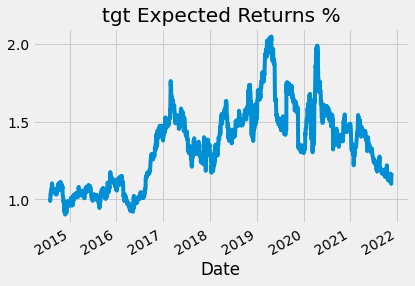

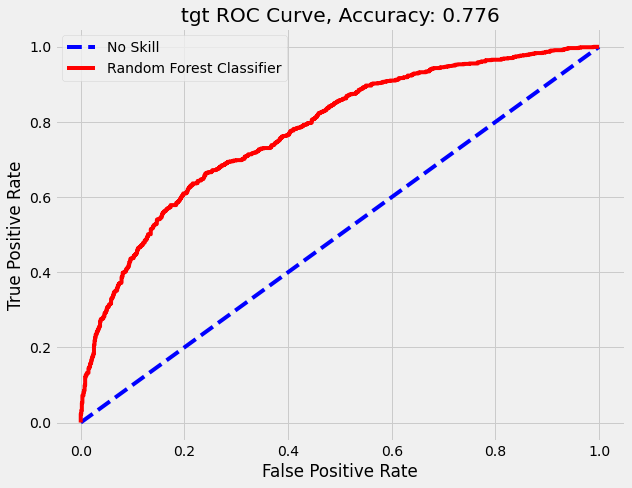

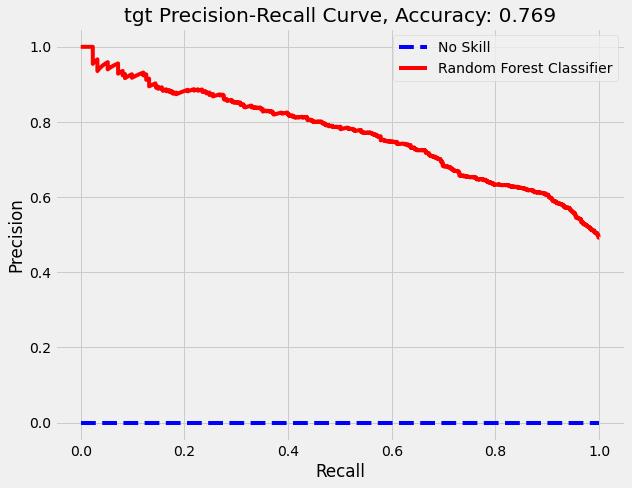

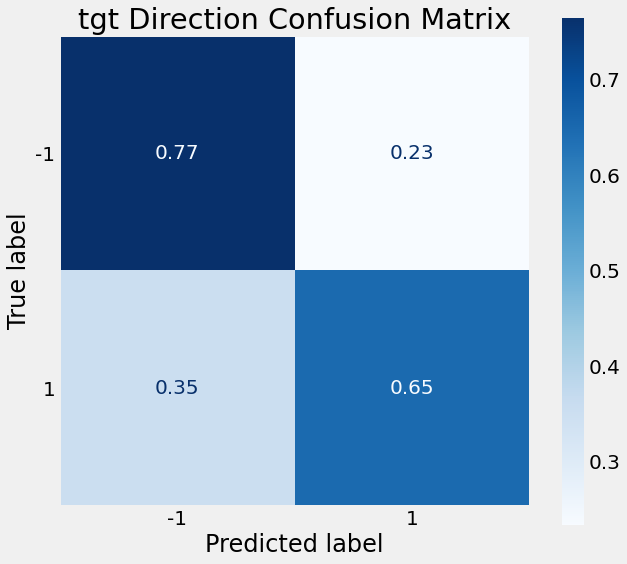

In [27]:
stock_name = 'tgt'
a.all_func(stock_name
           , start_dates[stock_name]
           , days_ahead = 1
           , model_name = model_name
           , days_back = 1
          )

### Data Frame of Predictions 1 3 5 Days

**NOTE:** Returns are for buys only.

In [28]:
print("Today's date:", today)
print("Current Time =", current_time)

Today's date: 2021-11-21
Current Time = 11:29:39


In [29]:
summary_df = a.pred_summary_df(start_dates1, stocks = [x for x in start_dates1], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,a,Hold or Sell,2.2088,Hold or Sell,2.3281,Hold or Sell,2.4676,18.4274
1,aapl,Hold or Sell,4.6087,Hold or Sell,3.2305,Hold or Sell,4.1934,663.7327
2,adbe,Hold or Sell,4.8105,Hold or Sell,5.0615,Hold or Sell,4.3597,211.9796
3,amat,Buy,11.4377,Buy,12.0829,Buy,11.0866,1133.5326
4,amd,Hold or Sell,24.9013,Hold or Sell,38.2942,Hold or Sell,49.6418,15.5771
5,amgn,Hold or Sell,2.1265,Hold or Sell,1.9233,Hold or Sell,1.7910,316.8143
6,amzn,Buy,1.5312,Buy,1.4613,Buy,1.3948,252.5566
7,baba,Buy,0.6492,Buy,0.7863,Buy,0.5889,0.7575
8,bac,Buy,1.9948,Buy,1.9300,Buy,2.6463,63.1040
9,bby,Hold or Sell,1.6825,Buy,1.6970,Hold or Sell,1.4525,1094.8123


In [30]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.9948, 1.93, 1.791, 63.104)

In [31]:
summary_df = a.pred_summary_df(start_dates2, stocks = [x for x in start_dates2], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,fslr,Hold or Sell,1.9179,Hold or Sell,2.7376,Hold or Sell,2.1528,-0.1317
1,goog,Buy,2.7885,Buy,2.9587,Buy,3.4622,11.7649
2,ibm,Buy,1.4193,Buy,1.5158,Buy,1.0820,28.2250
3,intc,Buy,4.2887,Buy,3.2530,Buy,4.0166,182.9010
4,iyw,Hold or Sell,2.6978,Hold or Sell,2.8479,Hold or Sell,1.9468,11.0194
5,ll,Buy,0.4633,Buy,0.7515,Buy,0.9510,-0.3267
6,lng,Buy,1.8660,Hold or Sell,1.9300,Hold or Sell,1.4814,28.8736
7,ma,Buy,1.2034,Buy,1.3593,Buy,1.4012,22.1143
8,mdb,Buy,1.2373,Buy,1.2921,Buy,1.2040,10.5783
9,msft,Hold or Sell,7.6276,Buy,8.1719,Hold or Sell,6.7840,322.0586


In [32]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.866, 1.93, 1.7717, 11.7649)

In [33]:
summary_df = a.pred_summary_df(start_dates3, stocks = [x for x in start_dates3], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,okta,Buy,1.0090,Buy,1.1266,Buy,1.1753,7.9141
1,orcl,Buy,2.2498,Buy,2.4710,Buy,2.3574,443.0858
2,qcom,Hold or Sell,3.1680,Hold or Sell,2.6053,Buy,3.1965,84.7969
3,qqq,Hold or Sell,2.2674,Hold or Sell,2.1075,Hold or Sell,2.3216,19.4929
4,srpt,Hold or Sell,1.2883,Hold or Sell,2.5722,Hold or Sell,1.5598,1.3707
5,tgt,Buy,2.7606,Buy,2.1909,Buy,1.9695,551.6794
6,tsla,Hold or Sell,5.0930,Hold or Sell,3.2449,Hold or Sell,3.1424,174.1479
7,tsm,Hold or Sell,4.6178,Hold or Sell,4.7688,Hold or Sell,4.1111,22.7715
8,v,Buy,1.4474,Buy,1.5761,Buy,1.8128,8.8799
9,vbiv,Buy,2.1202,Buy,3.2992,Buy,3.1861,-0.9224


In [34]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(2.1202, 2.1909, 2.0753, 13.6791)